# Preprocessing pipeline

Even though Kaggle has worked to collect and ordered the data, the JSON files need some work before becoming trainable dataset

This will be organized in a three step process


P1 ==>
-  We will reduce the number of JSON files we will run on (1 in 100). This is to produce a more managable dataset as we are only testing the waters with our model. The full data can be reprocessed if the model is found to be good.
-  The info in CSVs will be brought in to become columns in panda dataset

P2 ==>
- Tokens will be created from the markdowns and codes, with slightly different process
- features will be added (length of text, num of lines of code vs comments, dummy variables to replace left values - which should be encoded differently when it's a right value)

P3 ==>
- Vectorize the entry

P4 ==>
- We will split the dataset into two. One for each type of cell. As it would be easier to build a model predicting just code and just MarkDown. We could then use their output to train our full model

To be done next:
- replace order of cells with comparison relations `{ <, =, > }`, creating n(n-1)/2 combinations
- Dataframes/ CSVs will be concatenated


Timing will be mandatory for long steps and recorded for purpose of optimizing re-running strategies




In [70]:
df1 = pd.read_json("data/train/00001756c60be8.json")

In [48]:
train_order = pd.read_csv("data/train_orders.csv")
train_order.cell_order=train_order.cell_order.str.split()
train_order.sample(5)

,id,cell_order
101544,ba8ec0edee076c,"[b60583e5, f410fa1b, 710020c5, 667d777e, b3f52..."
121325,df2df37e4c6910,"[5c08e7c6, 7d256d36, 338b13e6, d31ca04d, 09d9d..."
16508,1e18a15c453f3e,"[248c3be9, fb743e4c, 29a3b7c6, 76d33b56, 05423..."
98435,b4d7d0c828d1c1,"[fe995b22, 591cd7c0, df5f3d91, 0b4de330, 2b461..."
10369,1305ae8cd924b0,"[e0afd782, ff4b7e44, 75ae29d3, cd435475, a089f..."


## Step P1: Skim dataset and add order information

In [494]:
%%time
#  time: 5sec / memory: 4MB
for index, row in train_order.iterrows():
    if index%1000==0:
        true_order = { h: i for i, h in enumerate(row["cell_order"])}

        # get dataframe
        df = pd.read_json(f"data/train/{row['id']}.json")
        df["true_order"] = df.index.map(true_order)
        #df["true_order_code"] = df[df.cell_type=="code"].rank()
        df.to_csv(f"data/train_P1/{row['id']}.csv")
        df.to_json(f"data/train_P1/{row['id']}.json")
        

CPU times: user 2.13 s, sys: 350 ms, total: 2.48 s
Wall time: 3.51 s


## Pipeline decorator

Write a decorator that encapsulates the process of opening files, performing transformations and saving them into csv 

In [582]:
import os
from random import shuffle
# this configures and returns the decorator
def pipeline(indir, outdir=None, breakafterone = False):

    # the decorator only receives the function and nothing else
    def pipelinedecor(funct):

        ## this will take the function and run it
        def pipelineinner(df, *args, **kwargs):
            df_ = df
            infiles = os.listdir(indir)
            #shuffle(infiles)
            for f in infiles:
                              
                if os.path.isfile(indir+f):

                    fn_ = f.split(".")
                    #print(indir, fn_)
                    
                    if fn_[1]=="json":
                        # df is just a dummy variable 
                        # as we will give it our own input and output
                        df = pd.read_json(indir+ f"{fn_[0]}.json")
                        # main function
                        df = funct(df, *args, **kwargs)
                        
                        if outdir:
                            df.to_csv(outdir+ f"{fn_[0]}.csv")
                            df.to_json(outdir+ f"{fn_[0]}.json")
                        if breakafterone:
                            break

            return df_ # return the dummy variable unchanged
        return pipelineinner  
    return pipelinedecor
    

## Step P2: NLP preprocessing

Markdown is transformed with common NLP preprocessing techniques

lower case, remove html tags (as markdown is html compatible), remove non-alphabetical characters,
remove digits

The markdown is then tokenized and further words are dropped if they are stop words, is digit number (unfortunately this sometimes remove chapter number which would be useful - opportunity for feature engineering), having length more than 20 characters (usually these are hashes)

Lastly the words pass through a stemmer to remove grammatical conjugations which confuses the computer

In [496]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist

extra_stopwords = ["li", "br", "http", "https", "www", "com", "class", "alert"]
re_html = re.compile(r'<[^>]+>')
re_char = re.compile(r"[^a-zA-Z0-9]")
#print(re_html.sub("",r'html_text = "<HTML><HEAD> This is HEAD <INSIDE> The is inside tag </INSIDE></HEAD> <BODY> This is BODY </BODY></HTML>'))

def preprocessing_unit(sourcetext: str):
    words = sourcetext.lower()
    words = re_html.sub('', words)
    #words = re.sub(r"[^a-zA-Z0-9]", " ", words)
    words = re_char.sub(' ', words)
    words=nltk.word_tokenize(words)
    words=[w for w in words if w not in stopwords.words("english") + extra_stopwords]
    words = [w for w in words if not w.isdigit()]
    words = [w for w in words if len(w)<20]
    words = [PorterStemmer().stem(w) for w in words]
    
    
    return words

### AST Unit

The AST unit generates left and right values, which is used in different ways

1. we get a list of variables, which might be replaced by dummy variable for training
2. we may build a directed graph which could help establish inheritance. These are strong features even as some authors of these notebooks are error-prone

In [497]:
import ast
re_nomagic = re.compile(r"^[!%].*\n?", flags=re.MULTILINE) # remove ipython magic (syntax error)

def ast_unit(sourcetext):

    sourcetext =  re_nomagic.sub(" ", sourcetext.lower())
    
    try:
        root = ast.parse(sourcetext)
    except SyntaxError as e:
        return ([],[])

    # all use of variables
    all_vars = {node.id for node in ast.walk(root) if isinstance(node, ast.Name)}
    
    # left values
    # currently only direct assignment of simple variables are 
    assignment = {n.id                      for node in ast.walk(root) \
                                            if isinstance(node, ast.Assign) \
                                            for n in node.targets\
                                            if isinstance(n, ast.Name) }


    all_imports =  {n.asname or n.name  for node in ast.walk(root) \
                                    if isinstance(node, (ast.Import, ast.ImportFrom)) \
                                    for n in node.names} 
 
    right_values = all_vars-assignment-all_imports
    left_values = assignment | all_imports
    return list(left_values), list(right_values)

source = "import pandas as pd \nfrom imblearn.over_sampling import "\
         "RandomOverSampler, SMOTE \nimport matplotlib; x = "\
         "train_df.drop(columns = \"target\", random_seed=seed)"
 
ast_unit(source)

(['pd', 'x', 'matplotlib', 'randomoversampler', 'smote'], ['seed', 'train_df'])

In [94]:
testphrase = df1.iloc[-2]["source"]
print(testphrase, " ==> ", preprocessing_unit(testphrase))
testphrase = df.iloc[-2]["source"]
print(testphrase, " ==> ", preprocessing_unit(testphrase))

Инициализация класса Data  ==>  ['data']
So some people are just not paying. Let's not worry about them.  ==>  ['people', 'paying', 'let', 'worry']


### Applying transformation
This applies the preprocessing and AST units above

In [499]:
%%time
all_tokens_in_all_nbs = []
all_codetokens_in_all_nbs = []
@pipeline("data/train_P1/","data/train_P2/", breakafterone=False)
def P2(df, all_tokens_in_all_nbs, all_codetokens_in_all_nbs):
    #df = pd.read_csv("data/train_P1/a8cb45eb4e091e.csv")
    ## ordinary text analysis
    df["tokens"] = df["source"].apply(preprocessing_unit)


    ## AST TREE
    df["codetokens"] = df[df.cell_type=="code"]["source"].apply(ast_unit)

    all_tokens_in_nb = df[df.cell_type=="markdown"]["tokens"].sum()
    all_tokens_in_all_nbs += all_tokens_in_nb

    all_codetokens_in_nb = df[df.cell_type=="code"]["codetokens"].apply(lambda x: x[0]+x[1]).sum()
    #print(df[df.cell_type=="code"]["codetokens"].apply(lambda x: x[1]))
    df.loc[df.cell_type=="code", "L-codetokens"] = df.loc[df.cell_type=="code",:].apply(lambda x: x.codetokens[0], axis =1)
    df.loc[df.cell_type=="code", "R-codetokens"] = df.loc[df.cell_type=="code",:].apply(lambda x: x.codetokens[1], axis =1)

    #df[df.cell_type=="code", "R-codetokens"] = df[df.cell_type=="code"]["codetokens"].apply(lambda x: x[1])
    all_codetokens_in_all_nbs += all_codetokens_in_nb

    return df

# 23sec/8MB for 0.1% data
_ = P2("dummy", all_tokens_in_all_nbs, all_codetokens_in_all_nbs) # input/ output is just dummy variable



CPU times: user 19.3 s, sys: 2.13 s, total: 21.5 s
Wall time: 22.9 s


In [369]:
all_counts = dict()
for size in 1, 2, 3, 4, 5:
    all_counts[size] = FreqDist(ngrams(all_tokens_in_all_nbs, size))
# No Ngrams for code
all_code_counts = FreqDist(all_codetokens_in_all_nbs)

## P2A: Plotting

Now checking the overall frequecy of words

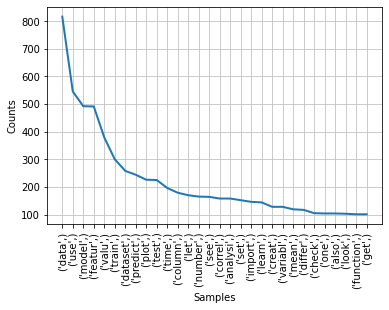

In [381]:
ax = all_counts[1].plot(30)

In [388]:
all_counts[1].most_common(10)

[(('data',), 816),
 (('use',), 545),
 (('model',), 492),
 (('featur',), 491),
 (('valu',), 379),
 (('train',), 300),
 (('dataset',), 258),
 (('predict',), 244),
 (('plot',), 226),
 (('test',), 225)]

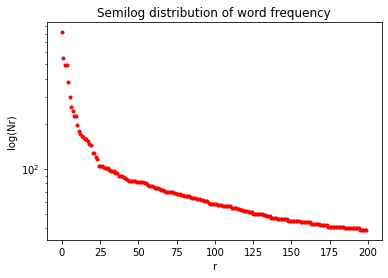

In [415]:
#print( all_counts[1].most_common(30))
log_rvsNr = [(key,value) for((key,), value) in all_counts[1].most_common(200) ]
log_rvsNr = list(zip(*log_rvsNr))

# plot the graph of log(r) vs log(Nr)
plt.semilogy(range(len(log_rvsNr[0])), log_rvsNr[1], 'r.')
plt.xlabel('r')
plt.ylabel('log(Nr)')
#plt.set_xticks(range(len(log_rvsNr[0])))
#plt.set_xticklabels(log_rvsNr[0])
plt.title('Semilog distribution of word frequency')
plt.show()

In [341]:
for ng, ngcount in all_counts[1].most_common(25):
    print(" ".join(ng), ngcount)

data 816
use 545
model 492
featur 491
valu 379
train 300
dataset 258
predict 244
plot 226
test 225
time 196
column 179
let 170
number 165
see 164
analysi 158
correl 158
set 152
import 146
learn 144
creat 128
variabl 128
mean 119
differ 117
check 105


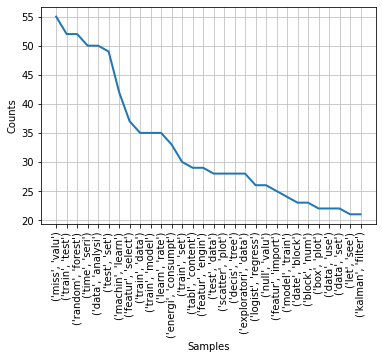

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [ ]:
all_counts[2].plot(30)

In [342]:
for size in 2,3:
    for ng, ngcount in all_counts[size].most_common(10):
        print(" ".join(ng), ngcount)

miss valu 55
train test 52
random forest 52
data analysi 50
time seri 50
test set 49
machin learn 42
featur select 37
train model 35
learn rate 35
exploratori data analysi 27
date block num 23
random forest classifi 13
median hous valu 13
one hot encod 12
target mean date 11
mean date block 11
train test set 10
machin learn model 10
item cnt day 10


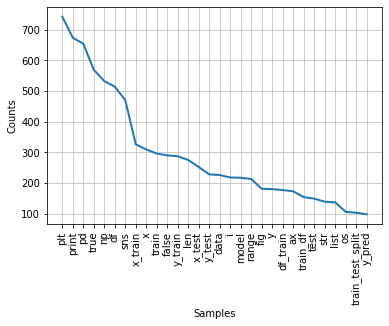

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [370]:
all_code_counts.plot(30)

In [417]:
for ng, ngcount in all_code_counts.most_common(200):
    print(ng, ngcount)

plt 742
print 673
pd 654
true 569
np 532
df 514
sns 470
x_train 326
x 309
train 296
false 290
y_train 287
len 275
x_test 252
y_test 228
data 226
i 218
model 217
range 213
fig 181
y 180
df_train 177
ax 173
train_df 154
test 149
str 139
list 137
os 106
train_test_split 103
y_pred 98
int 98
f 97
df_test 83
accuracy_score 74
_ 70
none 69
confusion_matrix 63
train_data 63
dict 62
enumerate 62
tf 60
col 54
round 54
torch 54
randomforestclassifier 54
filename 52
features 50
df_fe 50
px 49
test_df 48
k 47
logisticregression 47
datetime 45
dataset 45
filenames 45
dirname 45
decisiontreeclassifier 45
batch_size 44
df_house 44
classification_report 42
warnings 42
mean_squared_error 40
standardscaler 40
out 40
epochs 39
self 39
cross_val_score 39
tqdm 39
gridsearchcv 38
lr 38
go 38
y_val 38
history 37
results 37
kneighborsclassifier 37
train_new 37
c 36
zip 36
tweets 36
svc 35
p 34
row 33
metrics 33
dense 32
float 32
time 31
df_all 31
nn 31
n 31
car 31
cols 30
linearregression 30
clf 30
set 30
mcr

## Step P3: Vectorizing

Several options: one-hot encoding, TF-IDF (document defined as cells, as that is the unit we want to measure the )

In [526]:
df=pd.read_json("data/train_P2/ed44e2d85b6003.json")

In [583]:
%%time
#just a trick to make sure the pipeline produce side-effects
sentences_in_all_nbs = [pd.Series([])]
codesentences_in_all_nbs = [pd.Series([])]

@pipeline("data/train_P2/", None, breakafterone=False)
def P3A(df, sentences_in_all_nbs, codesentences_in_all_nbs):

    codesentences = df.loc[df.codetokens.values != None, "codetokens"]\
                                .map(lambda x: " ".join(x[0]+x[1]))
    codesentences_in_all_nbs[0] = pd.concat([codesentences_in_all_nbs[0], codesentences])
    sentences = df.loc[df.cell_type == "markdown", "tokens"]\
                                .map(lambda x: " ".join(x))
    sentences_in_all_nbs[0] = pd.concat([sentences_in_all_nbs[0], sentences])
    return df

# 0.4 sec for 0.1% data
_ = P3A("dummy", sentences_in_all_nbs, codesentences_in_all_nbs) 
# input/ output is just dummy variable

sentences_in_all_nbs=sentences_in_all_nbs[0]
codesentences_in_all_nbs = codesentences_in_all_nbs[0]

<timed exec>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<timed exec>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


CPU times: user 384 ms, sys: 26.1 ms, total: 410 ms
Wall time: 434 ms


In [579]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfVectorizer
#vectorizer = CountVectorizer(min_df=0)
#vectorizer.fit(all_code_counts)
tfidf_vectorizer = TfidfVectorizer(min_df=0.01)
tfidf_vectorizer.fit(codesentences_in_all_nbs[0])

print("length of TF-IDF vector", len(tfidf_vectorizer.get_feature_names_out()))
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names_out(),columns=["idf_weights"]) 
#df_idf.sort_values(by=['idf_weights'])
#print(df_idf)

# try transforming one line
v = tfidf_vectorizer.transform(codesentences_in_all_nbs[0][1:3])
df = pd.DataFrame(v[0].T.todense(),
                    index=tfidf_vectorizer.get_feature_names_out(),
                    columns=["TF-IDF"]) 
df.sort_values(by=["TF-IDF"],ascending=False)


#FIXME
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(corpus)

length of TF-IDF vector 111


,TF-IDF
data_train,0.740636
pd,0.671906
acum_tr_mse,0.000000
target,0.000000
str,0.000000
...,...
info_winnowing,0.000000
humidity_s,0.000000
humidity,0.000000
history,0.000000


## References

Berkeley Stat 157: Word2vec demonstration

https://nbviewer.org/url/courses.d2l.ai/berkeley-stat-157/slides/4_18/word2vec-gluon.ipynb

Applied Text Analysis with Python by Benjamin Bengfort, Rebecca Bilbro, Tony Ojeda

Chapter 4. Text Vectorization and Transformation Pipelines

https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

apply(), applymap(), map() in Pandas

https://towardsdatascience.com/introduction-to-pandas-apply-applymap-and-map-5d3e044e93ff

#### old code snippets

In [ ]:

## this configures and returns the decorator
#def pipeline(df,indir, outdir, skim=1, intype = "csv", outtype = "csv"):
#
#    # the decorator only receives the function and nothing else
#    def pipelinedecor(funct):
#
#        ## this will take the function and 
#        def pipelineinner(df, *args, **kwargs):
#            for index, row in train_order.iterrows():
#                if index%skim==0:
#
#                    if intype == "csv":
#                        df = pd.read_csv(indir+ f"{row['id']}.csv")
#                    elif intype == "json":
#                        df = pd.read_json(indir+ f"{row['id']}.json")
#
#                    # main function
#                    df = funct(df, *args, **kwargs)
#
#                    if outtype == "csv":
#                        df.to_csv(outdir+ f"{row['id']}.csv")
#                    elif outtype == "json":
#                        df.to_json(outdir+ f"{row['id']}.json")
#
#            return 
#        return pipelineinner  
#    return pipelinedecor
#    

In [ ]:
#@pipeline(df, "data/train/","data/train_P1/",skim=1000, intype="json")
#def P1(df):
#    df["true_order"] = df.index.map(true_order)
#    df["true_order_by_type"] = df.groupby("cell_type")["true_order"].rank()
#    return df

In [ ]:
#%%time
#P1(df) # 6 secs/ 2MB for 1 in 1000 skim rate

In [ ]:
text_ = """import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import linregress
from sklearn import preprocessing
from scipy import stats
import warnings
import math
import datetime
sns.set()
 sns.set_style('whitegrid')
# plt.style.use(""dark_background"")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
%matplotlib inline"""
print(re.sub(r"^[ !%].*\n?", " ", text_, flags=re.MULTILINE))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import linregress
from sklearn import preprocessing
from scipy import stats
import warnings
import math
import datetime
sns.set()
 # plt.style.use(""dark_background"")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
 
